**Name:** Talha Aslam

**Roll No.:** 24i-8067

**Name:** Muhammad Ahmer

**Roll No.:** 24i-7602

# Importing libraries

In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# 1. Load the Dataset



In [31]:

df = pd.read_csv("Mall_Customers.csv")

print("### Dataset Overview ###")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nData types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())


### Dataset Overview ###
Shape: (200, 5)

Columns:
 Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

Data types:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

First 5 rows:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


# 2. Data Preprocessing

In [32]:

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [33]:

# Drop CustomerID (not useful for modeling)
df.drop(columns=["CustomerID"], inplace=True, errors='ignore')

In [34]:
# Encode Gender
le = LabelEncoder()
df["Gender_enc"] = le.fit_transform(df["Gender"])
print("\nGender encoding:", dict(zip(le.classes_, le.transform(le.classes_))))



Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}


In [35]:
# Prepare features
features = ["Gender_enc", "Age", "Annual Income (k$)", "Spending Score (1-100)"]
X_raw = df[features]

In [36]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X = pd.DataFrame(X_scaled, columns=features)

print("\nScaled Features Sample:\n", X.head())


Scaled Features Sample:
    Gender_enc       Age  Annual Income (k$)  Spending Score (1-100)
0    1.128152 -1.424569           -1.738999               -0.434801
1    1.128152 -1.281035           -1.738999                1.195704
2   -0.886405 -1.352802           -1.700830               -1.715913
3   -0.886405 -1.137502           -1.700830                1.040418
4   -0.886405 -0.563369           -1.662660               -0.395980


# 3. Exploratory Data Analysis (EDA)



### Summary Statistics ###
        Gender         Age  Annual Income (k$)  Spending Score (1-100)  \
count      200  200.000000          200.000000              200.000000   
unique       2         NaN                 NaN                     NaN   
top     Female         NaN                 NaN                     NaN   
freq       112         NaN                 NaN                     NaN   
mean       NaN   38.850000           60.560000               50.200000   
std        NaN   13.969007           26.264721               25.823522   
min        NaN   18.000000           15.000000                1.000000   
25%        NaN   28.750000           41.500000               34.750000   
50%        NaN   36.000000           61.500000               50.000000   
75%        NaN   49.000000           78.000000               73.000000   
max        NaN   70.000000          137.000000               99.000000   

        Gender_enc  
count   200.000000  
unique         NaN  
top            NaN  

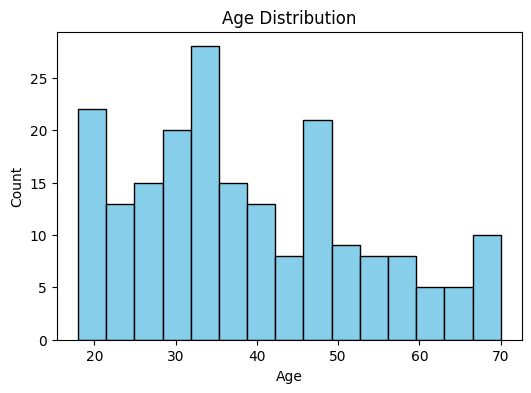

In [37]:

print("\n### Summary Statistics ###")
print(df.describe(include="all"))

# Histograms
plt.figure(figsize=(6,4))
plt.hist(df["Age"], bins=15, color='skyblue', edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


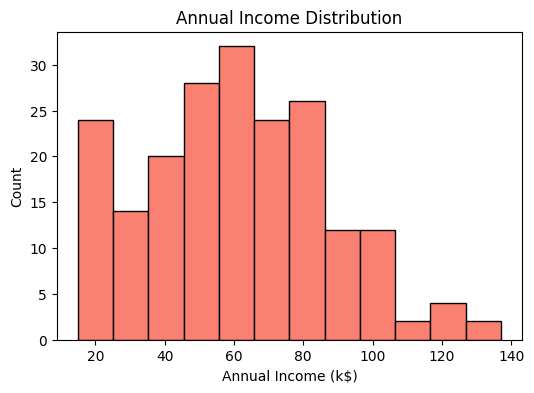

In [38]:
plt.figure(figsize=(6,4))
plt.hist(df["Annual Income (k$)"], bins=12, color='salmon', edgecolor='black')
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Count")
plt.show()

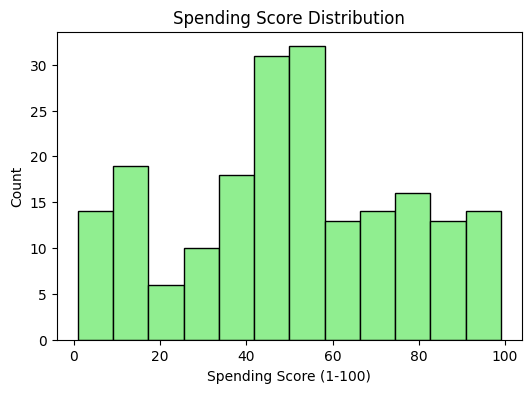

In [39]:
plt.figure(figsize=(6,4))
plt.hist(df["Spending Score (1-100)"], bins=12, color='lightgreen', edgecolor='black')
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score (1-100)")
plt.ylabel("Count")
plt.show()

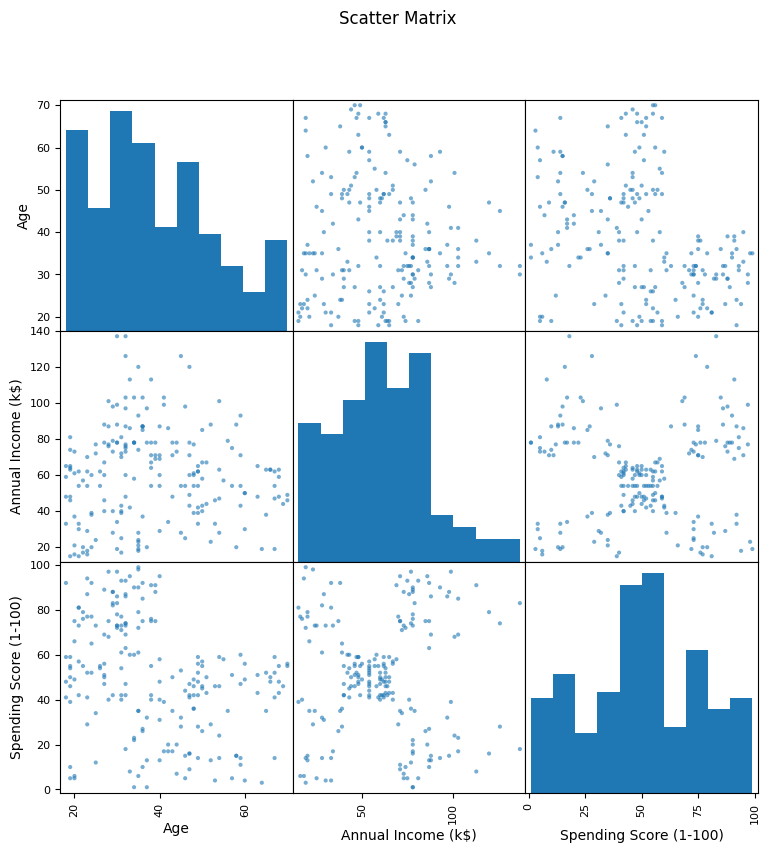

In [40]:
# Scatter matrix
numeric_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
scatter_matrix(df[numeric_cols], figsize=(9,9), alpha=0.6)
plt.suptitle("Scatter Matrix")
plt.show()

In [41]:

# Correlation
print("\nCorrelation Matrix:\n", df[numeric_cols].corr())


Correlation Matrix:
                              Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


# 4. Create Synthetic Target (Customer Segments)

In [42]:

kseg = 3
kmeans_for_target = KMeans(n_clusters=kseg, random_state=42)
seg_features = df[["Annual Income (k$)", "Spending Score (1-100)"]]
kmeans_labels = kmeans_for_target.fit_predict(seg_features)


In [43]:
# Order clusters by mean spending score
cluster_info = pd.DataFrame({
    "cluster": np.unique(kmeans_labels),
    "mean_spending": [seg_features.loc[kmeans_labels==c, "Spending Score (1-100)"].mean() for c in np.unique(kmeans_labels)],
    "mean_income": [seg_features.loc[kmeans_labels==c, "Annual Income (k$)"].mean() for c in np.unique(kmeans_labels)]
}).sort_values("mean_spending").reset_index(drop=True)

order_map = {row["cluster"]: idx for idx, row in cluster_info.iterrows()}
df["Segment"] = [order_map[c] for c in kmeans_labels]

print("\nCluster ordering (by mean spending score):\n", cluster_info)
print("\nDataset with new 'Segment' column:\n", df.head())


Cluster ordering (by mean spending score):
    cluster  mean_spending  mean_income
0        0      18.631579    87.000000
1        2      49.829268    44.154472
2        1      82.128205    86.538462

Dataset with new 'Segment' column:
    Gender  Age  Annual Income (k$)  Spending Score (1-100)  Gender_enc  \
0    Male   19                  15                      39           1   
1    Male   21                  15                      81           1   
2  Female   20                  16                       6           0   
3  Female   23                  16                      77           0   
4  Female   31                  17                      40           0   

   Segment  
0        1  
1        1  
2        1  
3        1  
4        1  


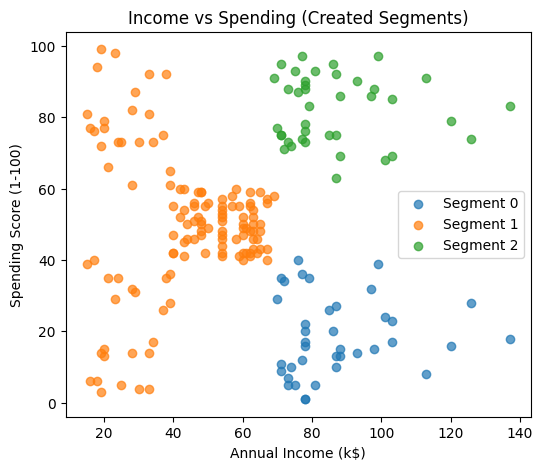

In [44]:
# Plot Income vs Spending colored by Segment
plt.figure(figsize=(6,5))
for seg in sorted(df["Segment"].unique()):
    subset = df[df["Segment"]==seg]
    plt.scatter(subset["Annual Income (k$)"], subset["Spending Score (1-100)"], label=f"Segment {seg}", alpha=0.7)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Income vs Spending (Created Segments)")
plt.legend()
plt.show()

# 5. Supervised Models (KNN & Naive Bayes)

In [45]:

y = df["Segment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [46]:

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print("\n### KNN Results ###")
print("Accuracy:", acc_knn)
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
cv_knn = cross_val_score(knn, X, y, cv=5)
print("Cross-Validation Mean:", cv_knn.mean())


### KNN Results ###
Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.97      1.00      0.98        31
           2       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.99      0.96      0.98        50
weighted avg       0.98      0.98      0.98        50

Confusion Matrix:
 [[ 8  1  0]
 [ 0 31  0]
 [ 0  0 10]]
Cross-Validation Mean: 0.975


In [47]:

# --- Gaussian Naive Bayes ---
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
acc_gnb = accuracy_score(y_test, y_pred_gnb)

print("\n### Gaussian Naive Bayes Results ###")
print("Accuracy:", acc_gnb)
print("\nClassification Report:\n", classification_report(y_test, y_pred_gnb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gnb))
cv_gnb = cross_val_score(gnb, X, y, cv=5)
print("Cross-Validation Mean:", cv_gnb.mean())


### Gaussian Naive Bayes Results ###
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        10

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

Confusion Matrix:
 [[ 9  0  0]
 [ 0 31  0]
 [ 0  0 10]]
Cross-Validation Mean: 0.97


# 6. KMeans Clustering (Unsupervised)

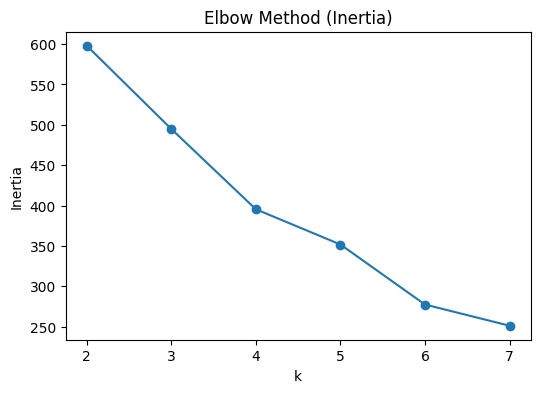

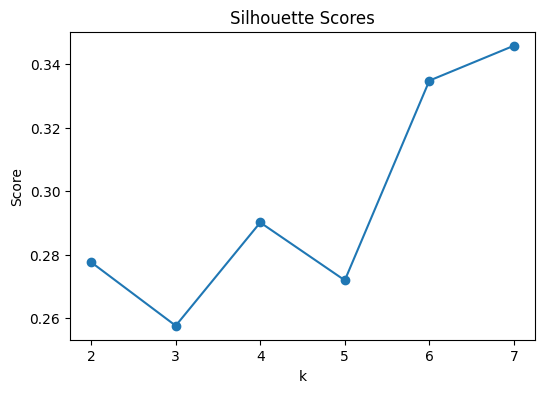

In [48]:

inertia = []
sil_scores = []
ks = range(2,8)
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Elbow plot
plt.figure(figsize=(6,4))
plt.plot(ks, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Silhouette plot
plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.show()

In [49]:
# Final KMeans
kmeans_final = KMeans(n_clusters=3, random_state=42)
df["KMeans_label"] = kmeans_final.fit_predict(X_scaled)


Cross-tab between Segment & KMeans_label:
 KMeans_label   0   1   2
Segment                 
0              2  33   3
1             69   0  54
2              0   2  37

Cluster Centers (scaled features):
    Gender_enc       Age  Annual Income (k$)  Spending Score (1-100)
0   -0.091932  0.955862           -0.529942               -0.423319
1    0.379888  0.098936            1.174964               -1.148009
2   -0.072010 -0.758818           -0.037211                0.747191


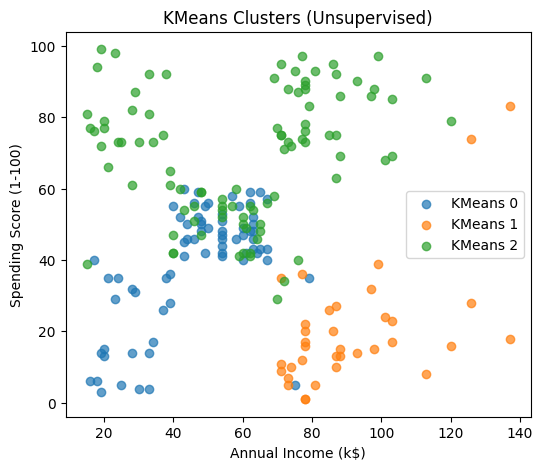

In [50]:
# Compare with synthetic segments
print("\nCross-tab between Segment & KMeans_label:\n", pd.crosstab(df["Segment"], df["KMeans_label"]))
print("\nCluster Centers (scaled features):\n", pd.DataFrame(kmeans_final.cluster_centers_, columns=features))

# Plot final clusters
plt.figure(figsize=(6,5))
for lbl in sorted(df["KMeans_label"].unique()):
    subset = df[df["KMeans_label"]==lbl]
    plt.scatter(subset["Annual Income (k$)"], subset["Spending Score (1-100)"], label=f"KMeans {lbl}", alpha=0.7)
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("KMeans Clusters (Unsupervised)")
plt.legend()
plt.show()

# 7. Summary

In [51]:


print("\n=== Final Summary ===")
print(f"Dataset Shape: {df.shape}")
print(f"KNN Accuracy: {acc_knn:.4f}")
print(f"GaussianNB Accuracy: {acc_gnb:.4f}")
print(f"KMeans Inertia (k=3): {kmeans_final.inertia_:.2f}")
print(f"KMeans Silhouette (k=3): {silhouette_score(X_scaled, df['KMeans_label']):.4f}")

# Optional: save new CSV
df.to_csv("Mall_Customers_with_segments.csv", index=False)
print("\nSaved: Mall_Customers_with_segments.csv")



=== Final Summary ===
Dataset Shape: (200, 7)
KNN Accuracy: 0.9800
GaussianNB Accuracy: 1.0000
KMeans Inertia (k=3): 494.80
KMeans Silhouette (k=3): 0.2576

Saved: Mall_Customers_with_segments.csv
